In [1]:
using Pkg
Pkg.activate(".")
#Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [2]:
using LinearAlgebra
using LimberJack
using CSV
using YAML
using JLD2
using PythonCall
using DataFrames
using NPZ
using Plots
using Interpolations
using Statistics
sacc = pyimport("sacc");

[ Info: Precompiling YAML [ddb6d928-2868-570f-bddf-ab3f9cf99eb6] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


In [3]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/wlwl.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")
fake_data_path = string("data/CosmoDC2/CosmoDC2_wlwl_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

meta_wlwl, files_wlwl = make_data(sacc_file, yaml_file;
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_wlwl.types = [
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_source_4


5-element Vector{String}:
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

In [4]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)

meta_gcgc, files_gcgc = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta_gcgc.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]


lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"

In [5]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc_gcwl_wlwl.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
#zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
#zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
#zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
#zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
#zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
#nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
#nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
#nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
#nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
#nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)


meta_3x2, files_3x2 = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)
                        #nz_source_0=nz_source_0,
                        #nz_source_1=nz_source_1,
                        #nz_source_2=nz_source_2,
                        #nz_source_3=nz_source_3,
                        #nz_source_4=nz_source_4)

meta_3x2.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


10-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

### Make Data

In [11]:
function model_wlwl(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
     meta=meta_wlwl, 
     files=files_wlwl,
     data=nothing)
    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)
    
    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    if data == nothing
        data = meta.data
    end
    d = theory .- data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

function model_gcgc(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
     meta=meta_gcgc, 
     files=files_gcgc,
     smooth_gc=0,
     data=nothing)
    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)

    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; 
    Nuisances=nuisances,
    int_gc="none")
    if data == nothing
        data = meta.data
    end
    d = theory .- data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

function model_3x2(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    meta=meta_3x2, 
    files=files_3x2,
    smooth_gc=0,
    data=nothing)
    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)

    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; 
        Nuisances=nuisances,
        int_gc="none")
    if data == nothing
        data = meta.data
    end
    d = theory .- data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

model_3x2 (generic function with 1 method)

In [12]:
t_wlwl, Xi2_wlwl = model_wlwl()
t_3x2, Xi2_3x2 = model_3x2()
t_gcgc, Xi2_gcgc = model_gcgc()
println("Xi2_wlwl = ", Xi2_wlwl/length(meta_wlwl.data), " ", Xi2_wlwl)
println("Xi2_gcgc = ", Xi2_gcgc/length(meta_gcgc.data), " ", Xi2_gcgc)
println("Xi2_3x2 = ", Xi2_3x2/length(meta_3x2.data), " ", Xi2_3x2)

Xi2_wlwl = 1.041750238736582 234.39380371573094
Xi2_gcgc = 1.941817588900475 75.73088596711852
Xi2_3x2 = 1.0596275662265249 494.84607342778713


In [ ]:
npzwrite("data/CosmoDC2/theories.npz", 
    t_wlwl=t_wlwl,
    t_gcgc=t_gcgc,
    t_3x2=t_3x2)

In [ ]:
#using ForwardDiff
#function grad_h(h)
#    function f(h)
#        t, Xi2 = model_3x2(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=h, ns=0.99651,
#            meta=meta_3x2, files=files_3x2, data=t_3x2)
#        return Xi2
#    end
#    return ForwardDiff.derivative(f, h)
#end

#function grad_Wm(Wm)
#    function f(Wm)
#        t, Xi2 = model_3x2(;Ωm=Wm, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
#            meta=meta_3x2, files=files_3x2, data=t_3x2)
#        return Xi2
#    end
#    return ForwardDiff.derivative(f, Wm)
#end

In [18]:
Wm = range(0.2, 0.5, length=200)
h = range(0.6, 0.9, length=200)
Wb = range(0.03, 0.07, length=200)

0.03:0.00020100502512562814:0.07

In [19]:
#h_grads = [grad_h(h_i) for h_i in h]
h_xi2_3x2 = [model_3x2(;h=h_i, data=t_3x2)[2] for h_i in h]
h_xi2_gcgc = [model_gcgc(;h=h_i, data=t_gcgc)[2] for h_i in h]
h_xi2_wlwl = [model_wlwl(;h=h_i, data=t_wlwl)[2] for h_i in h]

200-element Vector{Float64}:
 4.482219471215026
 4.357843764249516
 4.2354504012262035
 4.115141035851953
 3.9968547975840987
 3.8806051011782756
 3.7663757712533403
 3.6541810782904554
 3.5440146820830054
 3.435853306304097
 3.32965924195612
 3.2253852736388353
 3.1229530370129965
 ⋮
 5.29049577199698
 5.374786159443193
 5.459600434670702
 5.544900846130158
 5.6306191087417625
 5.716758317239416
 5.803343334524003
 5.890342259738523
 5.977748998851847
 6.065562228075282
 6.153760238788795
 6.24233346363978

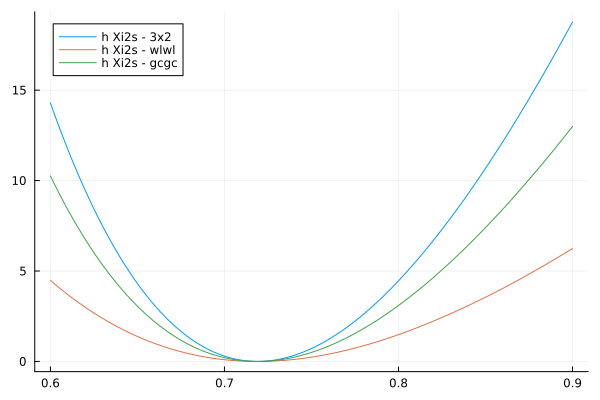

In [20]:
plot(h, h_xi2_3x2, label="h Xi2s - 3x2")
plot!(h, h_xi2_wlwl, label="h Xi2s - wlwl")
plot!(h, h_xi2_gcgc, label="h Xi2s - gcgc")

In [21]:
#Wm_grads = [grad_Wm(Wm_i) for Wm_i in Wm]
Wm_xi2_3x2 = [model_3x2(;Ωm=Wm_i, data=t_3x2)[2] for Wm_i in Wm]
Wm_xi2_gcgc = [model_gcgc(;Ωm=Wm_i, data=t_gcgc)[2] for Wm_i in Wm]
Wm_xi2_wlwl = [model_wlwl(;Ωm=Wm_i, data=t_wlwl)[2] for Wm_i in Wm]

200-element Vector{Float64}:
  396.155457103693
  381.31091781734153
  366.69291261683344
  352.30520473514304
  338.15148688653545
  324.2354555486894
  310.560766595504
  297.1310215069026
  283.94994687732884
  271.021172010146
  258.3482532913731
  245.93483426531347
  233.78451507880203
    ⋮
 4564.8949799074335
 4634.8118221590985
 4705.297937084482
 4776.353821520601
 4847.980550916928
 4920.178444932662
 4992.948548569875
 5066.291361549777
 5140.208030374968
 5214.698628464432
 5289.763572245086
 5365.4042170927305

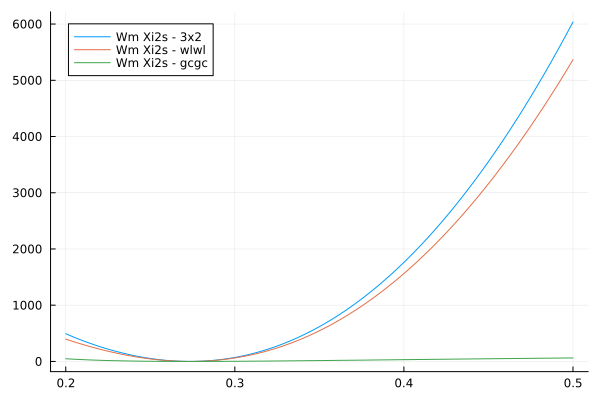

In [22]:
plot(Wm, Wm_xi2_3x2, label="Wm Xi2s - 3x2")
plot!(Wm, Wm_xi2_wlwl, label="Wm Xi2s - wlwl")
plot!(Wm, Wm_xi2_gcgc, label="Wm Xi2s - gcgc")